In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load and explore data
df = pd.read_csv('data/raw/Telco-Customer-Churn.csv', encoding='utf-8')
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
# Basic data info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [5]:
# Check target distribution
print("Churn distribution:")
print(df['Churn'].value_counts())
print("\nChurn percentage:")
print(df['Churn'].value_counts(normalize=True).apply(lambda x: f"{x:.1%}"))

# Data preprocessing
df.drop(columns=['customerID'], inplace=True)
df.drop_duplicates(inplace=True)
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# Handle TotalCharges conversion
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
print(f"Missing values in TotalCharges: {df['TotalCharges'].isnull().sum()}")
df = df.dropna(subset=['TotalCharges'])
print(f"Missing values after drop: {df['TotalCharges'].isnull().sum()}")

# Feature engineering
df['CLV'] = df['MonthlyCharges'] * df['tenure']
df['tenure_group'] = pd.cut(df['tenure'], bins=[0, 12, 24, 48, 60, np.inf], labels=['0-12', '13-24', '25-48', '49-60', '61+']).astype(str)

services = ['PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
df['TotalServices'] = df[services].apply(lambda row: sum(row == 'Yes'), axis=1)

df['Senior_NoPartner'] = ((df['SeniorCitizen'] == 1) & (df['Partner'] == 'No')).astype(int)
df['HasInternet'] = (df['InternetService'] != 'No').astype(int)
df['IsAutoPay'] = df['PaymentMethod'].apply(lambda x: 1 if 'automatic' in x.lower() else 0)
df['StreamingCount'] = df[['StreamingTV', 'StreamingMovies']].apply(lambda row: sum(row == 'Yes'), axis=1)

# Separate features and target
y = df['Churn']
X = df.drop('Churn', axis=1)

# Handle categorical variables
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges', 'CLV', 'TotalServices', 'Senior_NoPartner', 'HasInternet', 'IsAutoPay', 'StreamingCount']
cat_cols = X.drop(columns=num_cols).select_dtypes(include='object').columns

# Encode categorical variables
X_cat = pd.get_dummies(X[cat_cols], drop_first=True)
X_num = X[num_cols]
X = pd.concat([X_num, X_cat], axis=1)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)





Churn distribution:
Churn
No     5174
Yes    1869
Name: count, dtype: int64

Churn percentage:
Churn
No     73.5%
Yes    26.5%
Name: proportion, dtype: object
Missing values in TotalCharges: 11
Missing values after drop: 0


In [6]:
# Scale numerical features
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])


In [7]:


# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)


In [8]:
# Model training and evaluation
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:,1]
    
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    return model


Logistic Regression Results:
Accuracy: 0.7796005706134094

Confusion Matrix:
[[839 192]
 [117 254]]

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.81      0.84      1031
           1       0.57      0.68      0.62       371

    accuracy                           0.78      1402
   macro avg       0.72      0.75      0.73      1402
weighted avg       0.80      0.78      0.79      1402



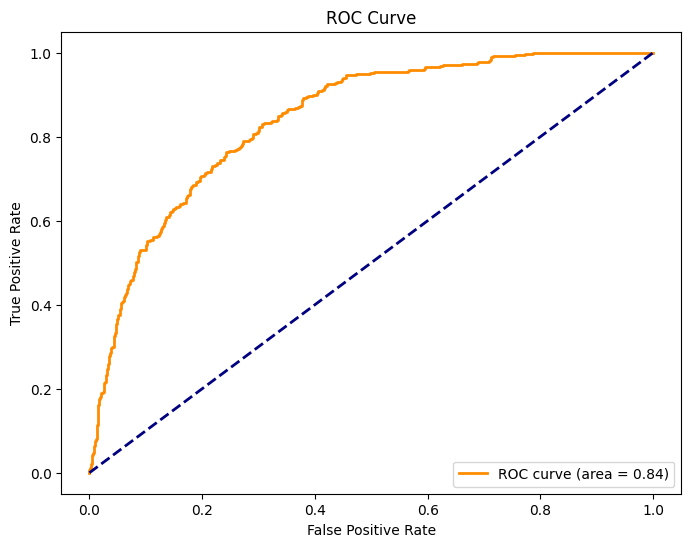


Random Forest Results:
Accuracy: 0.7724679029957204

Confusion Matrix:
[[862 169]
 [150 221]]

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.84      0.84      1031
           1       0.57      0.60      0.58       371

    accuracy                           0.77      1402
   macro avg       0.71      0.72      0.71      1402
weighted avg       0.78      0.77      0.77      1402



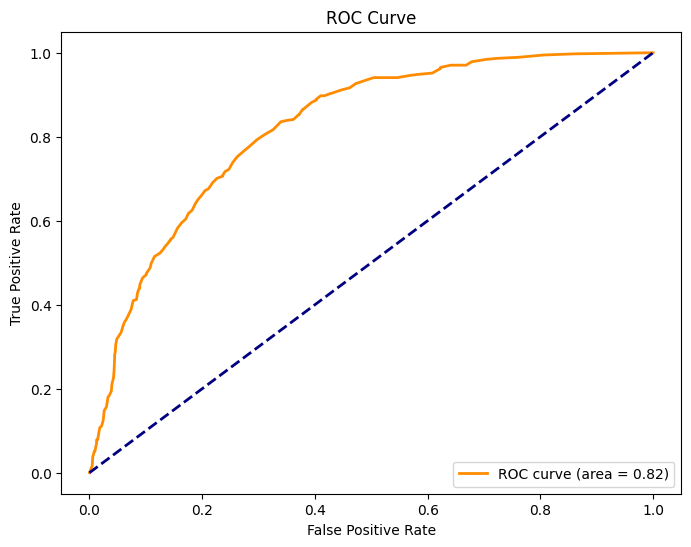


Gradient Boosting Results:
Accuracy: 0.7738944365192582

Confusion Matrix:
[[819 212]
 [105 266]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.79      0.84      1031
           1       0.56      0.72      0.63       371

    accuracy                           0.77      1402
   macro avg       0.72      0.76      0.73      1402
weighted avg       0.80      0.77      0.78      1402



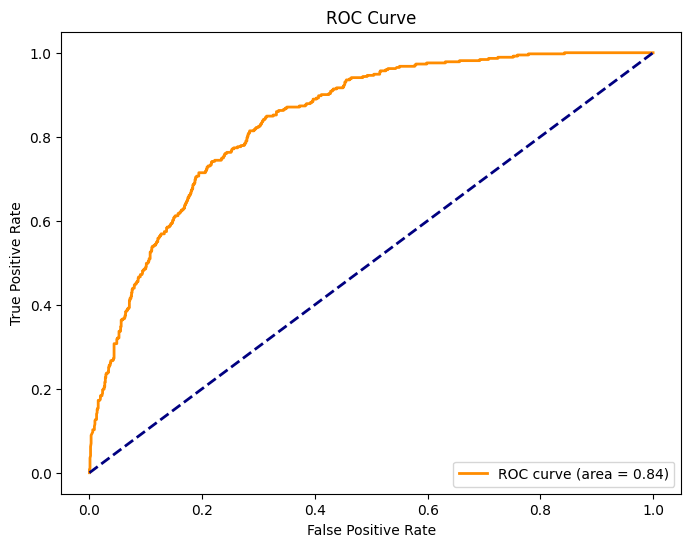


SVM Results:
Accuracy: 0.7746077032810271

Confusion Matrix:
[[827 204]
 [112 259]]

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.80      0.84      1031
           1       0.56      0.70      0.62       371

    accuracy                           0.77      1402
   macro avg       0.72      0.75      0.73      1402
weighted avg       0.80      0.77      0.78      1402



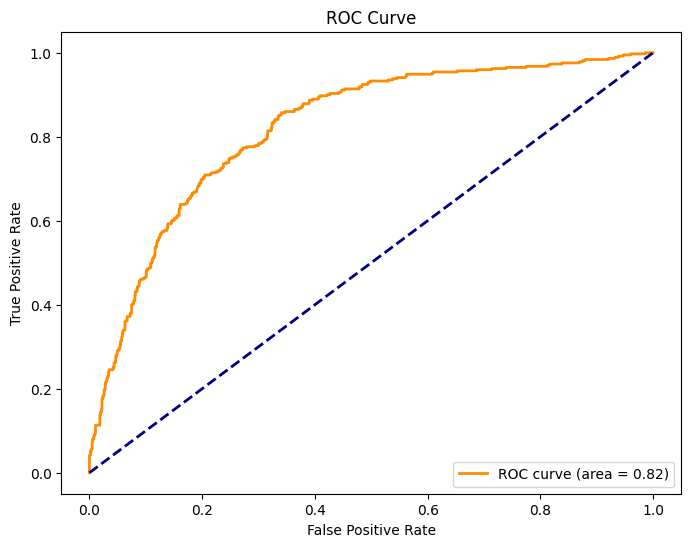

In [9]:
# Initialize and compare multiple models
models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced', random_state=42),
    'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(class_weight='balanced', probability=True, random_state=42)
}

for name, model in models.items():
    print(f"\n{name} Results:")
    evaluate_model(model, X_train_bal, y_train_bal, X_test, y_test)



In [10]:
# Hyperparameter tuning for best model (Random Forest)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

rf = RandomForestClassifier(class_weight='balanced', random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='f1')
grid_search.fit(X_train_bal, y_train_bal)

print("Best parameters:", grid_search.best_params_)
best_rf = grid_search.best_estimator_


Best parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}



Tuned Random Forest Results:
Accuracy: 0.7689015691868759

Confusion Matrix:
[[854 177]
 [147 224]]

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.83      0.84      1031
           1       0.56      0.60      0.58       371

    accuracy                           0.77      1402
   macro avg       0.71      0.72      0.71      1402
weighted avg       0.78      0.77      0.77      1402



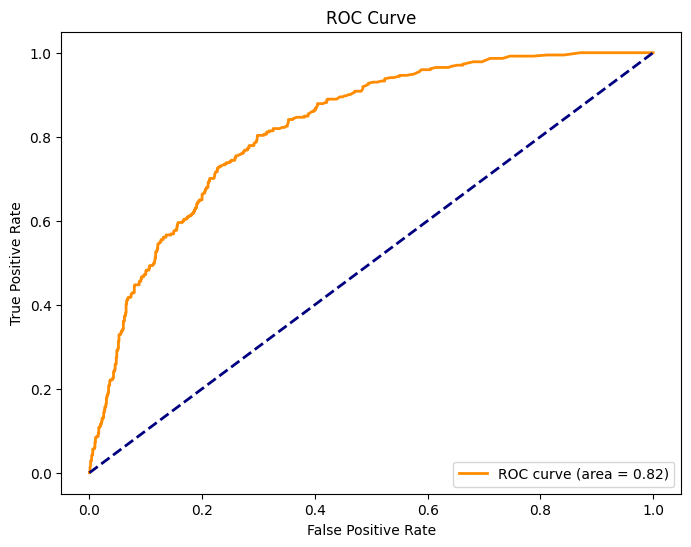

,n_estimators,200
,criterion,'gini'
,max_depth,20
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [11]:

# Evaluate tuned model
print("\nTuned Random Forest Results:")
evaluate_model(best_rf, X_train_bal, y_train_bal, X_test, y_test)



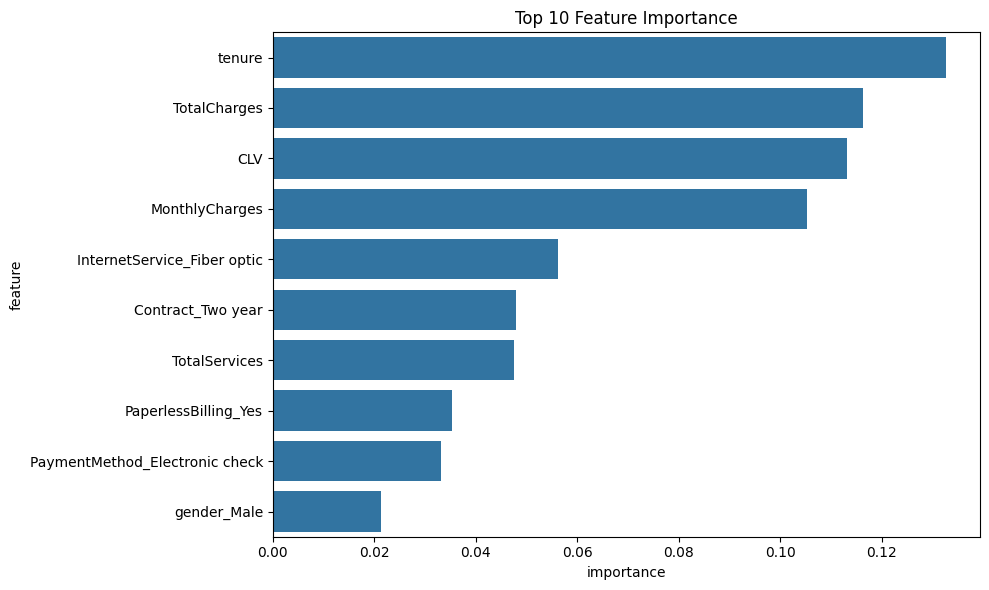

In [12]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_rf.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(10))
plt.title('Top 10 Feature Importance')
plt.tight_layout()
plt.show()